# Multi-round inference

In the previous tutorials, we have inferred the posterior using **single-round inference**. In **single-round inference**, we draw parameters from the prior, simulate the corresponding dat, and then train a neural network to obtain the posterior. However,  if one is interested in only one particular observation `x_o` sampling from the prior can be inefficient in the number of simulations because one is effectively learning a posterior estimate for all observations in the prior space. In this tutorial, we show how one can alleviate this issue by performing **multi-round inference** with `sbi`.  

**Multi-round inference** also starts by drawing parameters from the prior, simulating them, and training a neural network to estimate the posterior distribution. Afterwards, however, it continues inference in multiple rounds, focusing on a particular observation `x_o`. In each new round of inference, it draws samples from the obtained posterior distribution conditioned at `x_o` (instead of from the prior), simulates these, and trains the network again. This process can be repeated arbitrarily often to get increasingly good approximations to the true posterior distribution at `x_o`.

Running multi-round inference can be more efficient in the number of simulations, but it will lead to the posterior no longer being amortized (i.e. it will be accurate only for a specific observation `x_o`, not for any `x`).

Note, you can find the original version of this notebook at [https://github.com/mackelab/sbi/blob/main/tutorials/03_multiround_inference.ipynb](https://github.com/mackelab/sbi/blob/main/tutorials/03_multiround_inference.ipynb) in the `sbi` repository.

## Main syntax

In [ ]:
# 2 rounds: first round simulates from the prior, second round simulates from the obtained posterior.
num_rounds = 2
# The specific observation we want to focus the inference on.
x_o = torch.zeros(3,)

posteriors = []
proposal = None

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(
        simulator, 
        prior if proposal is None else proposal, 
        num_simulations=500
    )
     # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.add_data()`
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

## Linear Gaussian example
Below, we give a full example of inferring the posterior distribution over multiple rounds.

In [1]:
import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils

First, we define a simple prior and simulator and ensure that they comply with `sbi` by using `prepare_for_sbi`:

In [2]:
num_dim = 3
prior = utils.BoxUniform(low=-2*torch.ones(num_dim), 
                         high=2*torch.ones(num_dim))

In [3]:
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In [4]:
simulator, prior = prepare_for_sbi(linear_gaussian, prior)

Then, we instantiate the inference object:

In [5]:
inference = SNPE(prior=prior)

And we can run inference. In this example, we will run inference over `2` rounds, potentially leading to a more focused posterior around the observation `x_o`.

In [6]:
num_rounds = 2
x_o = torch.zeros(3,)

posteriors = []
proposal = None

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(
        simulator, 
        prior if proposal is None else proposal, 
        num_simulations=500
    )
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)


Neural network successfully converged after 123 epochs.



Using SNPE-C with atomic loss
Neural network successfully converged after 71 epochs.


 Note that, for `num_rounds>1`, the posterior is no longer amortized: it will give good results when sampled around `x=observation`, but possibly bad results for other `x`.

Once we have obtained the posterior, we can `.sample()`, `.log_prob()`, or `.pairplot()` in the same way as for the simple interface.

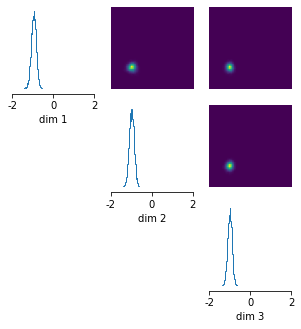

In [7]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = utils.pairplot(posterior_samples, limits=[[-2,2],[-2,2],[-2,2]], 
                   fig_size=(5,5))

We can always print the posterior to know how it was trained:

In [8]:
print(posterior)

Posterior conditional density p(θ|x) (multi-round). Evaluates and samples by default at x=[[0.0, 0.0, 0.0]].

This DirectPosterior-object was obtained with a SNPE-class method using a flow.
It allows to .sample() and .log_prob() the posterior and wraps the output of the .net to avoid leakage into regions with 0 prior probability.


## Warning for SNPE: do not pass the prior to `append_simulations()`

When you sampled from the **prior**, you should **not** pass the prior as proposal to `append_simulations()`. Instead, pass `None`.

In [ ]:
# DON'T do this:
theta, x = simulate_for_sbi(simulator, prior)
inference = inference.append_simulations(theta, x, prior)

# Instead, do:
theta, x = simulate_for_sbi(simulator, prior)
inference = inference.append_simulations(theta, x, None) # `None` is also the default.

Explanation: when a proposal is passed, SNPE uses a different loss-function. This loss-function can lead to numerical problems, e.g. [leakage](https://www.mackelab.org/sbi/faq/question_01/). When the prior is used, this different loss-function is not required, but it will nonetheless be triggered if you pass the `prior` instead of `None`.

This problem does not affect `SNLE` and `SNRE`. Neither of them accepts a `proposal` in `add_data()` as they do not require to change the loss-function.